<a href="https://colab.research.google.com/github/ZeroOFBright/Data-Science/blob/LSTM/LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict number  of passengers in last 12 months 

# Pre Process

In [ ]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

Load Dataset from seaborn

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


144 row = 12 Month * 12 Year

In [ ]:
flight_data.shape

(144, 3)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

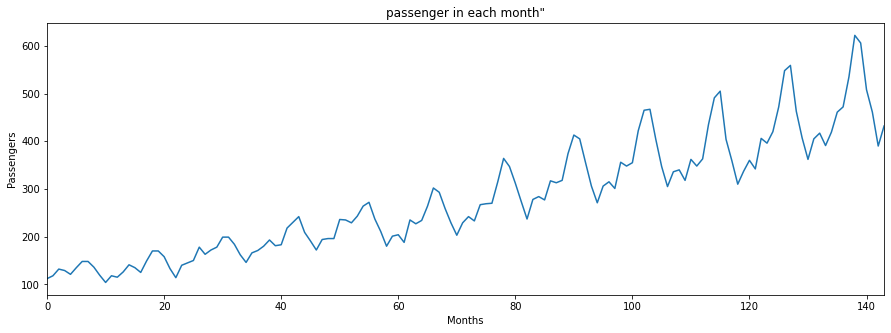

In [ ]:
plt.title('passenger in each month"')
plt.ylabel("Passengers")
plt.xlabel("Months")
plt.autoscale(axis="x",tight=True)
plt.plot(flight_data["passengers"])

In [ ]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [ ]:
passengers = flight_data['passengers'].values.astype(float)

In [ ]:
passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [ ]:
train_data = passengers[:-12]
len(train_data)

132

In [ ]:
test_data = passengers[-12:]
len(test_data)

12

Normalized Data in to range (-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

In [ ]:
train_data_normalized[:5]

array([[-0.96483516],
       [-0.93846154],
       [-0.87692308],
       [-0.89010989],
       [-0.92527473]])

Convert data to tensor 

In [ ]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [ ]:
train_window = 12

แปลงข้อมูลจาก ข้อมูลปกติ ให้อยู่ในรูปแบบ tuple  (12 เดือนแรก , เดือนที่13)  

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [ ]:
len(train_inout_seq)

120

In [ ]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

# Create LSTM Model

**ส่วนของ init**

input size = ขนาดจำนวนของ feature ใน input ในที่นี้มีแค่ จำนวนของคนโดยสาร เลยใส่ 1

hidden layer size = จำนวน hidden layer กับ จำนวน neurons ใน แต่ละlayer 

output size = จำนวน item output เนื่องจากต้องการหา จำนวนของผู้โดยสารใน 1 เดือน เลยใส่ 1  



**ในส่วนของ forward**

มีไว้สำหรับส่ง input_seq เข้าไปยัง lstm layer และ เมื่อออกจาก lstm layer ก็จะไหลไปเข้า linear layer




In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Traing the Model

In [ ]:
epochs = 300

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00651671
epoch:  26 loss: 0.00004014
epoch:  51 loss: 0.00014478
epoch:  76 loss: 0.00201592
epoch: 101 loss: 0.00004278
epoch: 126 loss: 0.00062607
epoch: 151 loss: 0.00003557
epoch: 176 loss: 0.00017674
epoch: 201 loss: 0.00057167
epoch: 226 loss: 0.00349262
epoch: 251 loss: 0.00014493
epoch: 276 loss: 0.00189478
epoch: 299 loss: 0.0006806817


# Test Prediction

In [ ]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [ ]:
test_inputs[fut_pred:]

[0.3998340368270874,
 0.2187078297138214,
 0.3427259027957916,
 0.3090786933898926,
 0.3628862202167511,
 0.4053935408592224,
 0.5424913763999939,
 0.6085094213485718,
 0.5470132827758789,
 0.34096938371658325,
 0.2837270498275757,
 0.5276466608047485]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[422.46224338]
 [381.25603126]
 [409.47014289]
 [401.81540275]
 [414.0566151 ]
 [423.72703055]
 [454.91678813]
 [469.93589336]
 [455.94552183]
 [409.0705348 ]
 [396.04790384]
 [451.53961533]]


In [ ]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


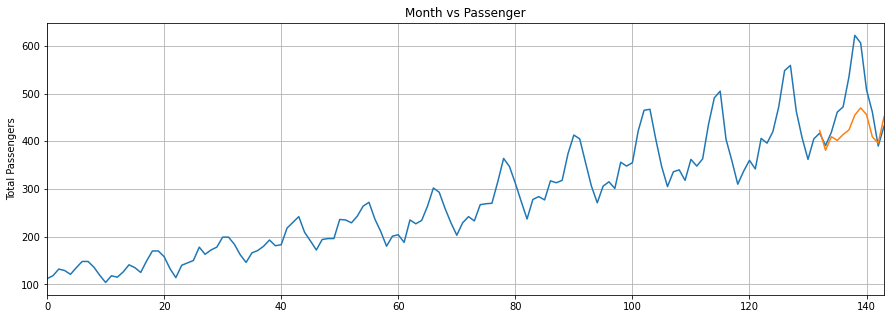

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

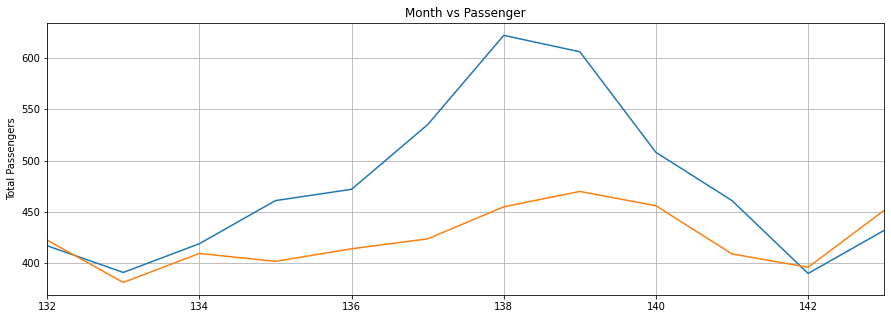

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()